In [1]:
#ref# https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py

# Comparing anomaly detection algorithms for outlier detection on 3D toy datasets


This example is an extension of anomaly comparison, [sckit-learn 2.7.1](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py). This experiment applied six algorithms ([`sklearn.covariance.EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope), [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM), [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest), [`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor), [`Extended Isolation Forest`](https://github.com/sahandha/eif/blob/master/eif.py), and [`USPORF`](https://github.com/neurodata/SPORF/blob/7c4cff4/Python/rerf/urerf.py#L12)) on 3D toy data simulation. 

## Simulation Setting
__Reference__: Madhyastha, Meghana, et al. "Geodesic Learning via Unsupervised Decision Forests." arXiv preprint arXiv:1907.02844 (2019).

set number of samples = 500 and outlier fraction = 0.15

## Inliers Setting
We rescale the inliers data to be within $X,Y,Z \in [-1,1]ู^3$ 

- __Linear__: each point $x$ is parameterized by $p = (0.4t, 0.6t, t)$, with $t \in (-1, 1)$ where $t$ is sampled from a grid with equal spacing. Each point has noise, std =$0.06$ in each axis.
- __Helix__: each point $x$ is parameterized by $p = (t \cos(t), t\sin(t), t)$, with $t \in (2 \pi, 9 \pi)$ on an equally spaced grid. Each point has noise, std =$0.06$ in each axis.
- __Sphere__: each point $x$ is parameterized by $p = (r \cos(u) \sin(v), r \sin(u) \sin(v), r \cos(v))$, with $u \in (0, 2\pi), v \in (0, \pi)$ and $r = 9$ where $u, v$ are sampled form a grid with equal spacing.
- __Gaussian Mixture__: each point $x$ is drawn from a mixture of Gaussian distributions: $P = \sum_{j=1}^3 \hat{w}_j \mathcal{N}(\mu_j,\Sigma),$ with $(\pi_1,\pi_2,\pi_3) = (0.2,0.2,0.2)(\hat{\mu}_1,\hat{\mu}_2,\hat{\mu}_3) = (\begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix},  \begin{bmatrix} 0 \\0\\0 \end{bmatrix} , \begin{bmatrix} 0.7 \\0.7\\0.7 \end{bmatrix} )$ and $\Sigma=\mathbb{I}$ is the identity matrix.



D_noise =  0


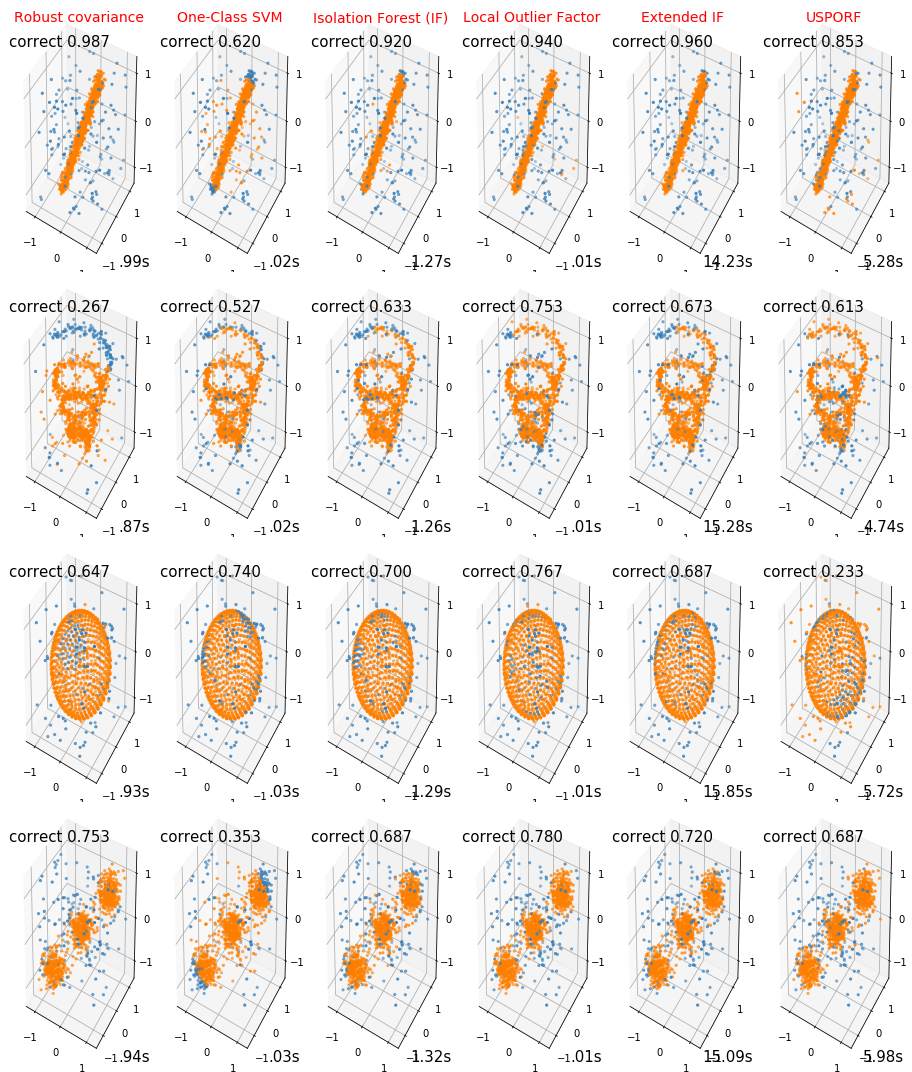

In [22]:
#### visualize data
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import time
import matplotlib
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from rerf.urerf import UnsupervisedRandomForest 
import eif as iso
from sklearn.metrics import adjusted_rand_score

# Example settings
D_noise = 0                                                             # number of uniform noise dimension
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
sd= 0.06

# Define datasets
    ## 1: Linear
t_lin = np.transpose(np.linspace(-1, 1,n_inliers))
X_lin = np.c_[0.4*t_lin + sd * np.random.randn(n_inliers) ,
              0.6*t_lin + sd * np.random.randn(n_inliers),t_lin+ sd * np.random.randn(n_inliers)]
    ## 2: Helix
t_hex = np.transpose(np.linspace(2*np.pi, 9*np.pi,n_inliers))
xline = t_hex*np.cos(t_hex) # before rescale
xline = xline/(max(xline)-min(xline))*2 + sd * np.random.randn(n_inliers)
yline = t_hex*np.sin(t_hex) # before rescale
yline = yline/(max(yline)-min(yline))*2 + sd * np.random.randn(n_inliers)
zline = (t_hex-(max(t_hex)+min(t_hex))/2)/(max(t_hex)-min(t_hex))*2 + sd * np.random.randn(n_inliers)
X_hex=np.c_[xline,yline,zline]
    ## 3: Sphere, equally distribution
    ## ref: https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2./samples
    increment = np.pi * (3. - np.sqrt(5.));
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = np.sqrt(1 - pow(y,2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x,y,z])
    return points
X_sph=np.array(fibonacci_sphere(samples=n_inliers))
    ## 4: Gaussian Mixture
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=3)
X_gau=make_blobs(centers=[[-0.7, -0.7,-0.7], [0, 0,0],
                          [0.7,0.7,0.7]], cluster_std=[0.2, 0.2,0.2],**blobs_params)[0]
datasets3D = [X_lin,X_hex,X_sph,X_gau]

# Define to data label
labels = np.concatenate([np.ones(n_inliers),-np.ones(n_outliers)], axis=0)  
# lbel 1 as inliers, -1 as outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest (IF)", IsolationForest(n_estimators=500,behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction)),
    ("Extended IF", iso.iForest(datasets3D[0], ntrees=500, sample_size=255, ExtensionLevel=1)),
    ("USPORF",UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=500, n_jobs=None,
                         projection_matrix='RerF'))] 

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-1.2, 1.2, 150),
                     np.linspace(-1.2, 1.2, 150))

plt.figure(figsize=(13,15)) #?
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.98, wspace=.05,hspace=.01) #?
# fig = plt.figure()
plot_num = 1
rng = np.random.RandomState(42)

for i_dataset3D, X in enumerate(datasets3D):
    # Add outliers (i = index (0,1,..), X = data set)
    X = np.concatenate([X, rng.uniform(low=-1.2, high=1.2,
                       size=(n_outliers, 3))], axis=0)                  # add uniform outlier
    X_noise =rng.uniform(low=-1.2, high=1.2,size=(n_samples, D_noise))      # add uniform noise dimension
    X = np.append(X, X_noise, axis=1)
    
    for name, algorithm in anomaly_algorithms: 
        t0 = time.time()
        if name == "Extended IF":                                       # Extended IF doesn't has fit function
            algorithm = iso.iForest(X, ntrees=500, sample_size=min(256,len(X)), ExtensionLevel=D_noise+2)
        else:
            algorithm.fit(X)
        t1 = time.time()

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        elif name == "Extended IF":                                     # Extended IF doesn't have predict function
            Score = algorithm.compute_paths(X_in=X)                     # compute anomaly score
            sE = np.argsort(Score)
            indicesE = sE[-int(np.ceil(outliers_fraction*X.shape[0])):] # outlier indices 
            y_pred = np.ones(X.shape[0])
            y_pred[indicesE] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
            
        elif name == "USPORF":                                          # USPORF doesn't have predict function
            sim_mat = algorithm.transform()                             # create similarity matrix
            sim_sum = sim_mat.sum(axis=1)                               
            sU = np.argsort(sim_sum)
            indicesU = sU[:int(np.floor(outliers_fraction*X.shape[0]))] # outlier indeces
            y_pred = np.ones(X.shape[0])
            y_pred[indicesU] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
        else:
            y_pred = algorithm.fit(X).predict(X)
            
        #calculate % correction score
        count_correct = list(y_pred + labels)
        score = count_correct.count(-2)/n_outliers
        t2 = time.time()    
        
        ax=plt.subplot(len(datasets3D), len(anomaly_algorithms), plot_num, projection='3d')        
        if i_dataset3D == 0:
            plt.title(name, size=14, color = 'red') # function "name" to be title        
        colors = np.array(['#377eb8', '#ff7f00'])
        ax.scatter3D(X[:, 0], X[:, 1],X[:,2], s=5, color=colors[((y_pred + 1) // 2)]) # label color
 
        ax.text2D(.99, .01, ('%.2fs' % (t2 - t0)).lstrip('0'),
                  transform=plt.gca().transAxes, size=15,
                  horizontalalignment='right')                         # Calculation time
        ax.text2D(.01, .85, ('correct %.3f' % score).lstrip('0'),
                  transform=plt.gca().transAxes, size=15,
                  horizontalalignment='left')                          # ARI score
        plot_num += 1
print("D_noise = ", str(D_noise))
plt.show()

D_noise =  10


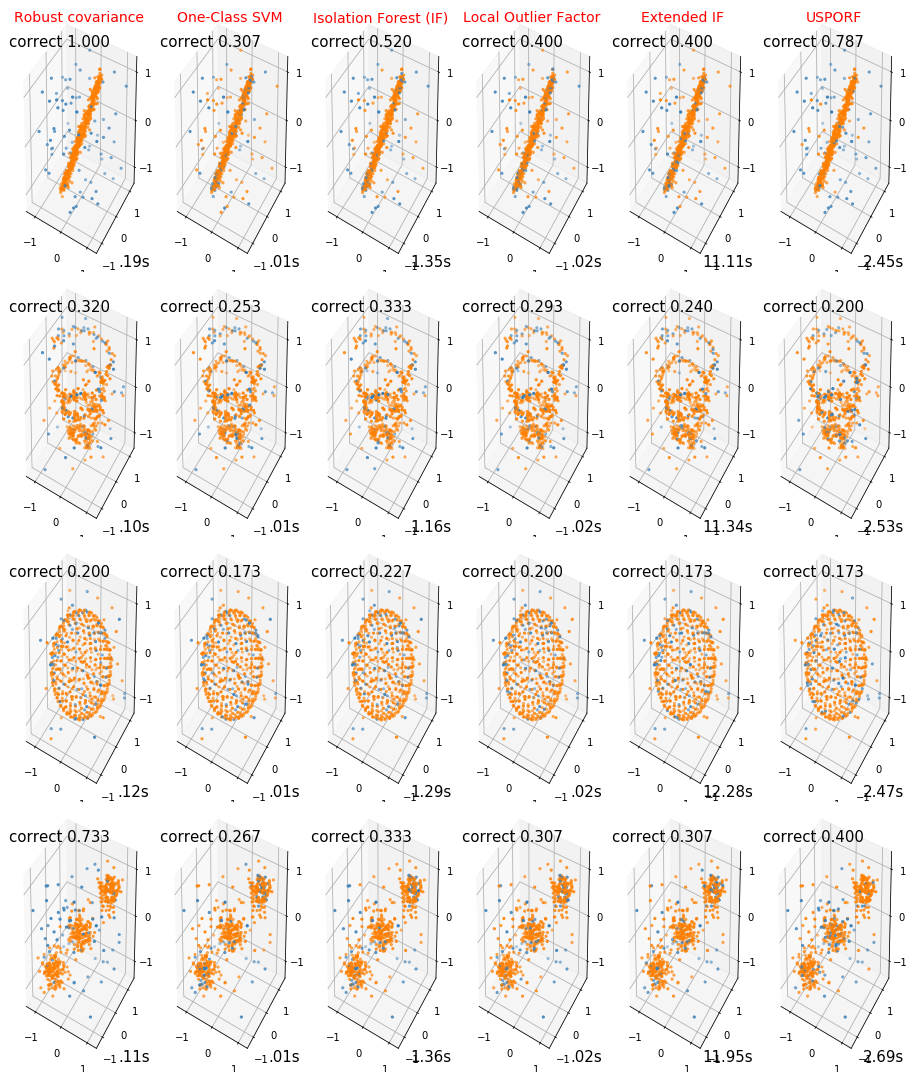

In [24]:
#### visualize data
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import time
import matplotlib
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from rerf.urerf import UnsupervisedRandomForest 
import eif as iso
from sklearn.metrics import adjusted_rand_score

# Example settings
D_noise = 10                                                             # number of uniform noise dimension
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
sd= 0.06

# Define datasets
    ## 1: Linear
t_lin = np.transpose(np.linspace(-1, 1,n_inliers))
X_lin = np.c_[0.4*t_lin + sd * np.random.randn(n_inliers) ,
              0.6*t_lin + sd * np.random.randn(n_inliers),t_lin+ sd * np.random.randn(n_inliers)]
    ## 2: Helix
t_hex = np.transpose(np.linspace(2*np.pi, 9*np.pi,n_inliers))
xline = t_hex*np.cos(t_hex) # before rescale
xline = xline/(max(xline)-min(xline))*2 + sd * np.random.randn(n_inliers)
yline = t_hex*np.sin(t_hex) # before rescale
yline = yline/(max(yline)-min(yline))*2 + sd * np.random.randn(n_inliers)
zline = (t_hex-(max(t_hex)+min(t_hex))/2)/(max(t_hex)-min(t_hex))*2 + sd * np.random.randn(n_inliers)
X_hex=np.c_[xline,yline,zline]
    ## 3: Sphere, equally distribution
    ## ref: https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere
def fibonacci_sphere(samples=1,randomize=True):
    rnd = 1.
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2./samples
    increment = np.pi * (3. - np.sqrt(5.));
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = np.sqrt(1 - pow(y,2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x,y,z])
    return points
X_sph=np.array(fibonacci_sphere(samples=n_inliers))
    ## 4: Gaussian Mixture
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=3)
X_gau=make_blobs(centers=[[-0.7, -0.7,-0.7], [0, 0,0],
                          [0.7,0.7,0.7]], cluster_std=[0.2, 0.2,0.2],**blobs_params)[0]
datasets3D = [X_lin,X_hex,X_sph,X_gau]

# Define to data label
labels = np.concatenate([np.ones(n_inliers),-np.ones(n_outliers)], axis=0)  
# lbel 1 as inliers, -1 as outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest (IF)", IsolationForest(n_estimators=500,behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction)),
    ("Extended IF", iso.iForest(datasets3D[0], ntrees=500, sample_size=255, ExtensionLevel=1)),
    ("USPORF",UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=500, n_jobs=None,
                         projection_matrix='RerF'))] 

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-1.2, 1.2, 150),
                     np.linspace(-1.2, 1.2, 150))

plt.figure(figsize=(13,15)) #?
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.98, wspace=.05,hspace=.01) #?
# fig = plt.figure()
plot_num = 1
rng = np.random.RandomState(42)

for i_dataset3D, X in enumerate(datasets3D):
    # Add outliers (i = index (0,1,..), X = data set)
    X = np.concatenate([X, rng.uniform(low=-1.2, high=1.2,
                       size=(n_outliers, 3))], axis=0)                  # add uniform outlier
    X_noise =rng.uniform(low=-1.2, high=1.2,size=(n_samples, D_noise))      # add uniform noise dimension
    X = np.append(X, X_noise, axis=1)
    
    for name, algorithm in anomaly_algorithms: 
        t0 = time.time()
        if name == "Extended IF":                                       # Extended IF doesn't has fit function
            algorithm = iso.iForest(X, ntrees=500, sample_size=min(256,len(X)), ExtensionLevel=D_noise+2)
        else:
            algorithm.fit(X)
        t1 = time.time()

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        elif name == "Extended IF":                                     # Extended IF doesn't have predict function
            Score = algorithm.compute_paths(X_in=X)                     # compute anomaly score
            sE = np.argsort(Score)
            indicesE = sE[-int(np.ceil(outliers_fraction*X.shape[0])):] # outlier indices 
            y_pred = np.ones(X.shape[0])
            y_pred[indicesE] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
            
        elif name == "USPORF":                                          # USPORF doesn't have predict function
            sim_mat = algorithm.transform()                             # create similarity matrix
            sim_sum = sim_mat.sum(axis=1)                               
            sU = np.argsort(sim_sum)
            indicesU = sU[:int(np.floor(outliers_fraction*X.shape[0]))] # outlier indeces
            y_pred = np.ones(X.shape[0])
            y_pred[indicesU] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
        else:
            y_pred = algorithm.fit(X).predict(X)
            
        #calculate % correction score
        count_correct = list(y_pred + labels)
        score = count_correct.count(-2)/n_outliers
        t2 = time.time()    
        
        ax=plt.subplot(len(datasets3D), len(anomaly_algorithms), plot_num, projection='3d')        
        if i_dataset3D == 0:
            plt.title(name, size=14, color = 'red') # function "name" to be title        
        colors = np.array(['#377eb8', '#ff7f00'])
        ax.scatter3D(X[:, 0], X[:, 1],X[:,2], s=5, color=colors[((y_pred + 1) // 2)]) # label color
 
        ax.text2D(.99, .01, ('%.2fs' % (t2 - t0)).lstrip('0'),
                  transform=plt.gca().transAxes, size=15,
                  horizontalalignment='right')                         # Calculation time
        ax.text2D(.01, .85, ('correct %.3f' % score).lstrip('0'),
                  transform=plt.gca().transAxes, size=15,
                  horizontalalignment='left')                          # ARI score
        plot_num += 1
print("D_noise = ", str(D_noise))
plt.show()